In [1]:
import pandas as pd
import sklearn.linear_model as lm
import sklearn.preprocessing as pre
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import seaborn as sns

import harness

In [2]:
flights_train = pd.read_csv('data/flights_train.csv', index_col=0)
flights_test = pd.read_csv('data/flights_test.csv', index_col=0)

In [3]:
flights_clean = harness.clean_train(flights_train)

In [4]:
def add_hour_decimal(df, col):
    result = df.copy()
    result[col + '_hours'] = result[col] // 100 + (result[col] % 100) / 60
    return result

In [5]:
def add_all_hour_decimal(df):
    df = add_hour_decimal(df, 'crs_dep_time')
    df = add_hour_decimal(df, 'crs_arr_time')
    return df

In [6]:
def powers_of(df, degree):
    column_name = df.columns[0]
    scaled = pre.StandardScaler().fit_transform(df)
    dep_powers = pre.PolynomialFeatures(degree=degree).fit_transform(scaled)[:, 1:]
    return pd.DataFrame(
        dep_powers, columns = [
            f'{column_name}_{i + 1}' for i in range(degree)
        ]
    )

In [7]:
def powers_of_time(df):
    df = add_all_hour_decimal(df)
    return powers_of(df[['crs_dep_time_hours']], 6).join(
        powers_of(df[['crs_arr_time_hours']], 6)
    )

In [8]:
transformer = harness.DataTransformer(
    powers_of_time
)

In [9]:
x_train, y_train = transformer.extract_transform(flights_clean)

In [10]:
def train_model():
    linreg = lm.Ridge(random_state=42)
    grid_search = ms.GridSearchCV(
        linreg, dict(alpha=[10 ** i for i in range(-6, 7)]),
    )
    grid_search.fit(x_train.values, y_train.values)
    harness.save(grid_search.best_estimator_, 'time_of_day_model_no_transform')

In [11]:
train_model()

In [12]:
linreg = harness.load('time_of_day_model_no_transform')
linreg_model = harness.TrainedModel(linreg, transformer)

In [13]:
linreg.coef_

array([[ 3.93402906e+00, -2.23436401e+00, -8.37823762e-01,
         4.71046177e-01,  5.79300234e-06, -4.81620057e-02,
         3.87983717e+00,  2.68992466e+00, -1.16227268e+00,
        -1.08051138e+00,  1.51557426e-01,  1.23742867e-01]])

In [14]:
linreg_model.validate(harness.clean_train(flights_test))[3]

R squared: 0.00995
R squared (early = 0): -0.0233
R squared (only delay): -0.2

In [15]:
linreg_model.submit(
    'data/test.csv', 'time_of_day_no_transform_submission.csv', 'predicted_delay'
)

So this model is pretty bad. It's worse than just assuming the average delay. We can see why looking at the graphs below. Time of day predicts taxi time well, but this doesn't translate well into actual delays measurements.

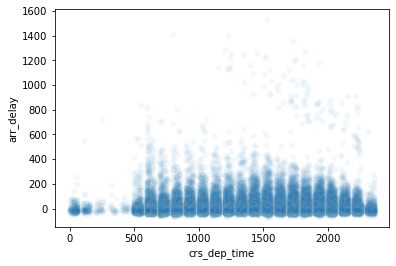

In [16]:
sns.scatterplot(x=flights_clean.crs_dep_time, y=y_train.arr_delay, alpha=0.05)
plt.show()

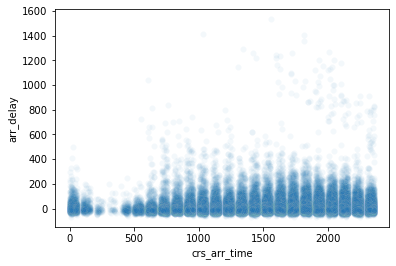

In [17]:
sns.scatterplot(x=flights_clean.crs_arr_time, y=y_train.arr_delay, alpha=0.05)
plt.show()